## Load Data

In [1]:
import os 
import numpy as np
import skimage
from skimage import transform
from PIL import Image

In [2]:
ROOT = '/home/thomas/tmp/tf/dataset/'

In [7]:
# TODO: change to import
import os

class DatasetCreator:

    def __init__(self, root, disallowed=['.DS_Store', '']):
        self.root = root
        self.disallowed = disallowed

    @staticmethod
    def _is_image_file(f_name):
        return f_name.endswith('.png') or f_name.endswith('.jpeg') or f_name.endswith('.jpg')

    def get_image_files(self, n=None):
        self.all_image_files = {}
        self.categorical_mapping = {}
        self.n_samples = 0
        for path, _, files in os.walk(self.root):
            label = path.split('/')[-1]
            for f in files:
                if self._is_image_file(f):
                    self.all_image_files[label] = self.all_image_files.get(label, []) + [os.path.join(path, f)]
        if n is None:
            
            for label, file_list in self.all_image_files.items():
                # update categorical mapping
                self.categorical_mapping[label] = len(self.categorical_mapping)
                # update total sample count
                self.n_samples += len(file_list)
            
            return self.n_samples, self.all_image_files
        else:
            image_files = {}
            top_n_labels = [ t[0] for t in sorted([(k, len(v)) for k,v in self.all_image_files.items()], key=lambda x: -x[1])[:n]]
            for label in top_n_labels:
                image_files[label] = self.all_image_files[label]
                self.categorical_mapping[label] = len(self.categorical_mapping)
                self.n_samples += len(self.all_image_files[label])
            return self.n_samples, image_files
            
    def get_label(self, mapped):
        assert(isinstance(mapped, int))
        for k, v in self.categorical_mapping.items():
            if mapped == v:
                return k


In [27]:
N_CLASSES = 17

In [28]:
creator = DatasetCreator(ROOT)

In [29]:
# here we only get the 50 most prevalent classes in the dataset
n_samples, img_files = creator.get_image_files(n=N_CLASSES) 
categorical_label_mapping = creator.categorical_mapping
n_labels = len(categorical_label_mapping)
assert(n_labels == N_CLASSES)
n_labels

17

In [30]:
n_samples

1298

In [31]:
im_shape = (128,128,3)

X = np.zeros(shape=(tuple([n_samples] + list(im_shape))))
y = np.zeros(shape=n_samples)
idx = 0
for label, files in img_files.items():
    for f in files:
        img = np.asarray(Image.open(f))    
        X[idx,:,:,:] = transform.resize(img, im_shape)
        y[idx] = categorical_label_mapping[label]
        idx += 1

In [32]:
X.shape, y.shape

((1298, 128, 128, 3), (1298,))

## EDA

label: adho mukha svanasana


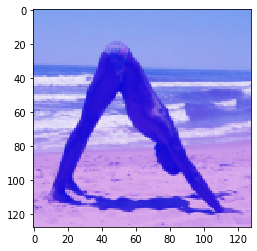

In [33]:
import matplotlib.pyplot as plt

print(f'label: {creator.get_label(int(y[-1]))}')
_ = plt.imshow(X[-1,:,:,:])

## Training

In [34]:
SEED = 42

In [35]:
import tensorflow as tf
tf.__version__

'2.1.0'

### Input pipeline

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=SEED)

In [37]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# add ZSA whitening
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
train_gen.fit(X_train)

### Architecture

In [45]:
tf.keras.backend.clear_session()

In [46]:
# can't use categorical_crossentropy loss w/ int labels
# https://github.com/keras-team/keras/issues/11749

model = tf.keras.Sequential()

for _ in range(3):
    model.add(tf.keras.layers.Conv2D(64, kernel_size=2))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

for _ in range(2):
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(.1))

model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))

model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def generate_cnn_model(
    n_conv_layers,
    n_dense_layers,
    b_labels,
    dense_layer_nodes=64,
    pooling='max',
    dropout_ratio=0.1
):
    
    model = tf.keras.Sequential()
    
    for _ in range(n_conv_layers):
        model.add(tf.keras.layers.Conv2D(64, kernel_size=2))
        if pooling == 'max':
            model.add(tf.keras.layers.MaxPooling2D())
        elif pooling == 'avg':
            model.add(tf.keras.layers.AvgPooling2D())
        else:
            raise Exception("Can only use pooling == max | avg")
        model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Flatten())
    
    for _ in range(n_dense_layers):
        model.add(tf.keras.layers.Dense(dense_layer_nodes), activation='relu')
        model.add(tf.keras.layers.Dropout(dropout_ratio))
    
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))
    return model

### Train

In [47]:
BATCH_SIZE = 32
EPOCHS = 100

In [48]:
model.fit(
    train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch = X_train.shape[0] / BATCH_SIZE,
    epochs=EPOCHS
)

Train for 34.46875 steps
Epoch 1/100
35/34 [==============================] - 27s 762ms/step - loss: 3.8034 - accuracy: 0.0834
Epoch 2/100
35/34 [==============================] - 26s 748ms/step - loss: 3.1938 - accuracy: 0.1088
Epoch 3/100
35/34 [==============================] - 26s 737ms/step - loss: 3.0365 - accuracy: 0.1233
Epoch 4/100
35/34 [==============================] - 23s 655ms/step - loss: 2.9409 - accuracy: 0.1296
Epoch 5/100
35/34 [==============================] - 24s 700ms/step - loss: 2.7935 - accuracy: 0.1405
Epoch 6/100
35/34 [==============================] - 25s 709ms/step - loss: 2.7822 - accuracy: 0.1487
Epoch 7/100
35/34 [==============================] - 24s 684ms/step - loss: 2.7041 - accuracy: 0.1478
Epoch 8/100
35/34 [==============================] - 23s 649ms/step - loss: 2.6755 - accuracy: 0.1532
Epoch 9/100
35/34 [==============================] - 24s 693ms/step - loss: 2.5610 - accuracy: 0.1768
Epoch 10/100
35/34 [==============================] - 23s

35/34 [==============================] - 27s 775ms/step - loss: 1.6039 - accuracy: 0.4424
Epoch 81/100
35/34 [==============================] - 28s 812ms/step - loss: 1.5659 - accuracy: 0.4687
Epoch 82/100
35/34 [==============================] - 29s 828ms/step - loss: 1.5632 - accuracy: 0.4651
Epoch 83/100
35/34 [==============================] - 27s 784ms/step - loss: 1.5990 - accuracy: 0.4615
Epoch 84/100
35/34 [==============================] - 27s 773ms/step - loss: 1.5397 - accuracy: 0.4578
Epoch 85/100
35/34 [==============================] - 28s 795ms/step - loss: 1.5135 - accuracy: 0.4841
Epoch 86/100
35/34 [==============================] - 27s 784ms/step - loss: 1.5791 - accuracy: 0.4606
Epoch 87/100
35/34 [==============================] - 29s 819ms/step - loss: 1.5456 - accuracy: 0.4651
Epoch 88/100
35/34 [==============================] - 28s 800ms/step - loss: 1.5602 - accuracy: 0.4651
Epoch 89/100
35/34 [==============================] - 26s 737ms/step - loss: 1.5452 - 

In [49]:
model.evaluate(X_test, y_test, batch_size=16)

195/195 [==============================] - 1s 7ms/sample - loss: 2.4334 - accuracy: 0.2205


[2.43342535618024, 0.22051282]

### Evaluate

## Predicting

7.0 utkatasana
7 utkatasana


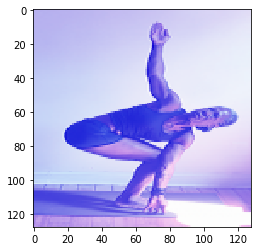

In [61]:
test_idx = 5

label = creator.get_label(int(y_test[test_idx]))
print(y_test[test_idx], label)

plt.imshow(X_test[test_idx])
y_pred = model.predict(np.reshape(X_test[test_idx], tuple([1] + list(X_test[0].shape)))).argmax()
print(y_pred, creator.get_label(int(y_pred)))

## Random Search

In [129]:
# HPP's
N_CONV_LAYERS = [ i for i in range(2,5) ]
CONV_FILTERS = [ 2 ** n for n in range(5,7) ]

N_DENSE_LAYERS = [ i for i in range(2,5) ]
DENSE_LAYER_NODES = [2 ** n for n in range(5,9) ]


# include VGG16, Resnet50, what else?

# add weight decay
# use AUC & other appropriate metrics

In [ ]:
# Bonus time: use k-fold CV